In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time

import os

root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

# Outliers

An outlier is a data point that is very different from most of the remaining data.
Hawkins formally defined the notion of an outlier as follows
> An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.

One of the most common method used to found outliers is the Tukey Fence.
This method is based on the interquartile range (IQR):

if $Q_1$ and $Q_3$ are the lower and upper quartile, an outlier is any observation outside the range:

<center> $[ Q_1 - 1.5(Q_3 - Q_1), Q_3+1.5(Q_3-Q_1) ]$ </center>

In [3]:
def count_outliers(df, index):
    '''
    :returtn: two dataframes
        one with the row corresponding to outliers
        one with the row corresponding to not outliers
    '''
    values = df.iloc[:, index].values
    Q = np.quantile(values, [.25, .75])
    Q1 = Q[0]
    Q3 = Q[1]
    IQR = Q3-Q1
    QL = Q1 - 3*IQR #1.5
    QH = Q3 + 3*IQR #1.5
    
    out_row = df[(df[index] < QL) | (df[index]>QH)]
    in_row = df[(df[index] >= QL) & (df[index] <= QH)]
    
    return in_row, out_row

## Outliers Info

<IPython.core.display.Javascript object>


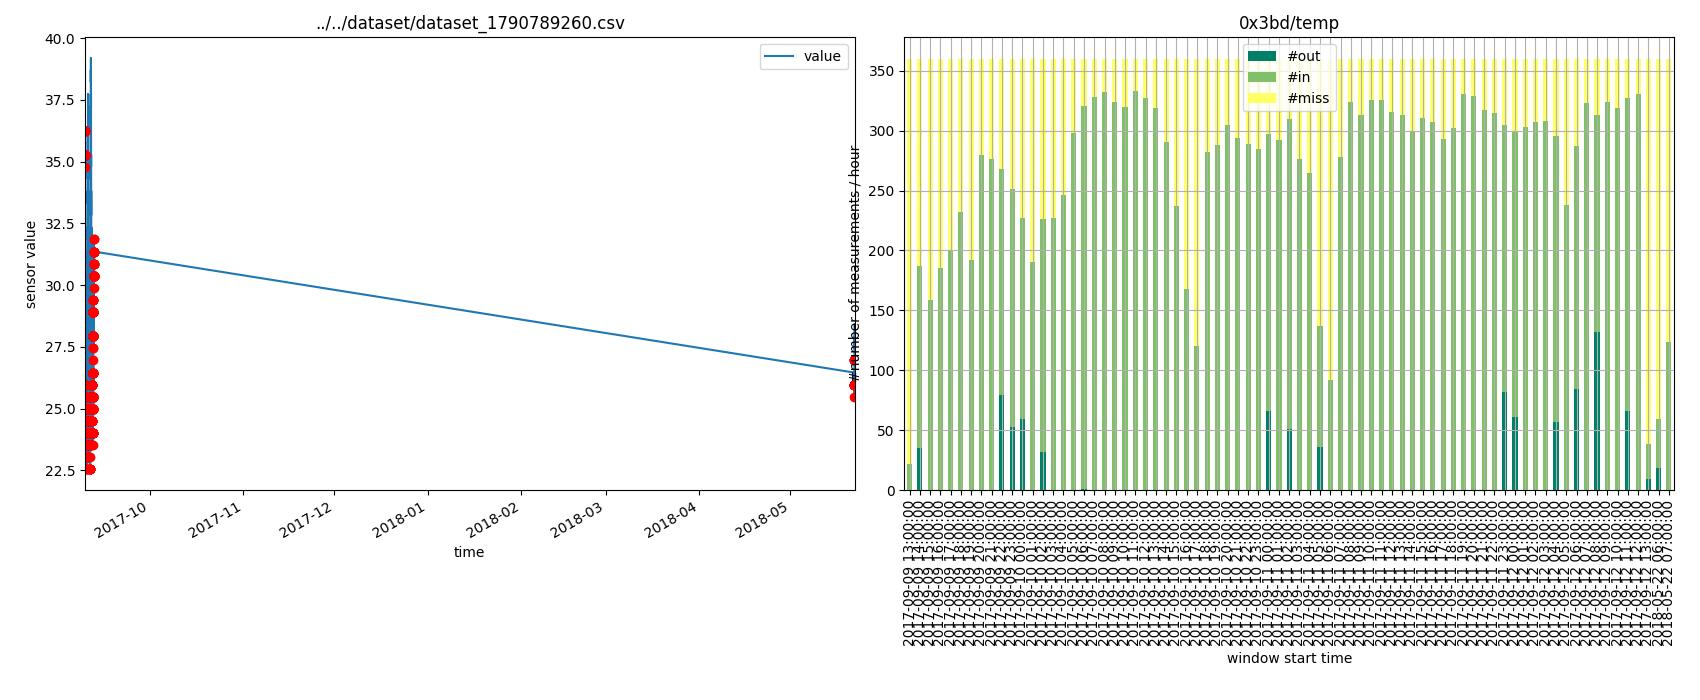

<IPython.core.display.Javascript object>


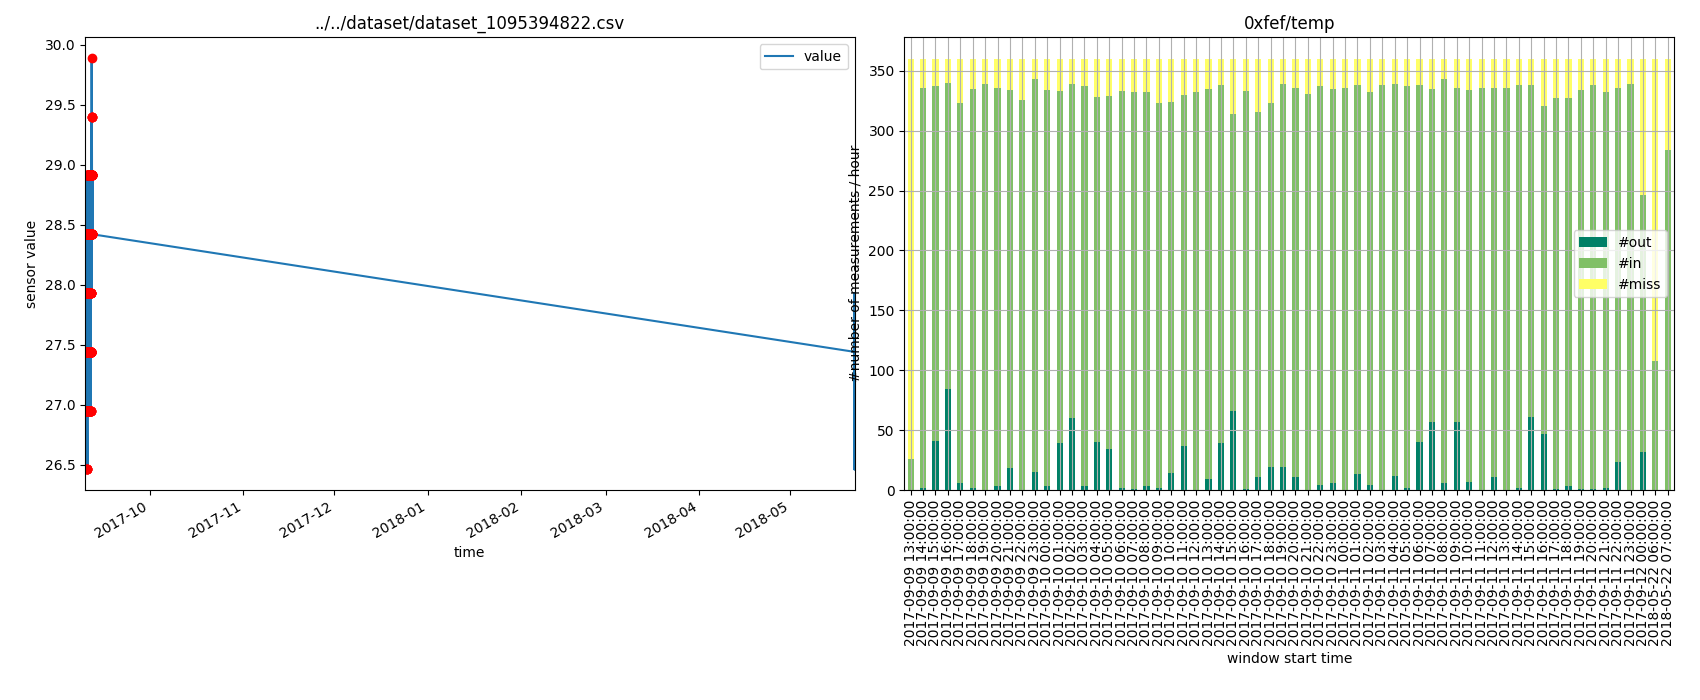

<IPython.core.display.Javascript object>


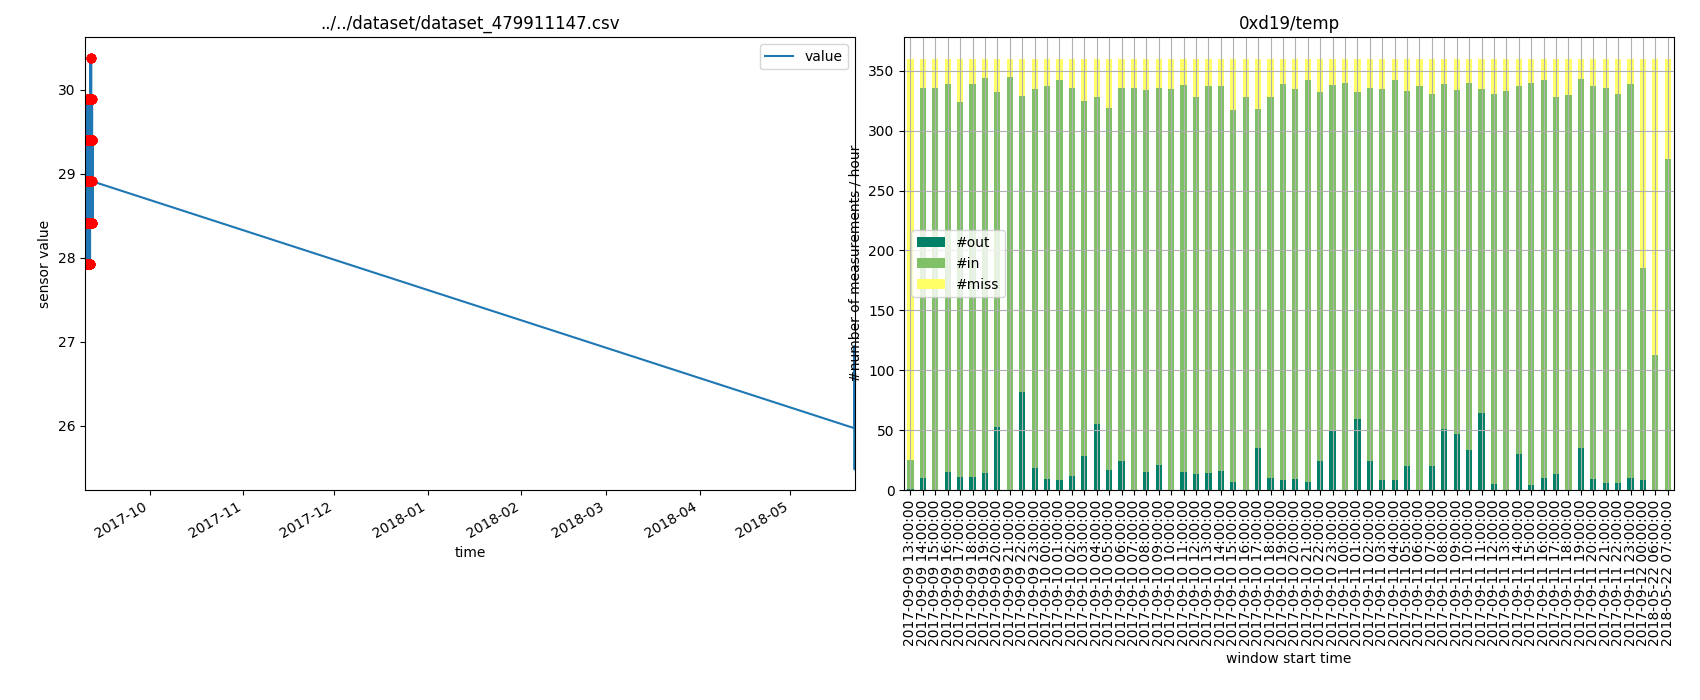

<IPython.core.display.Javascript object>


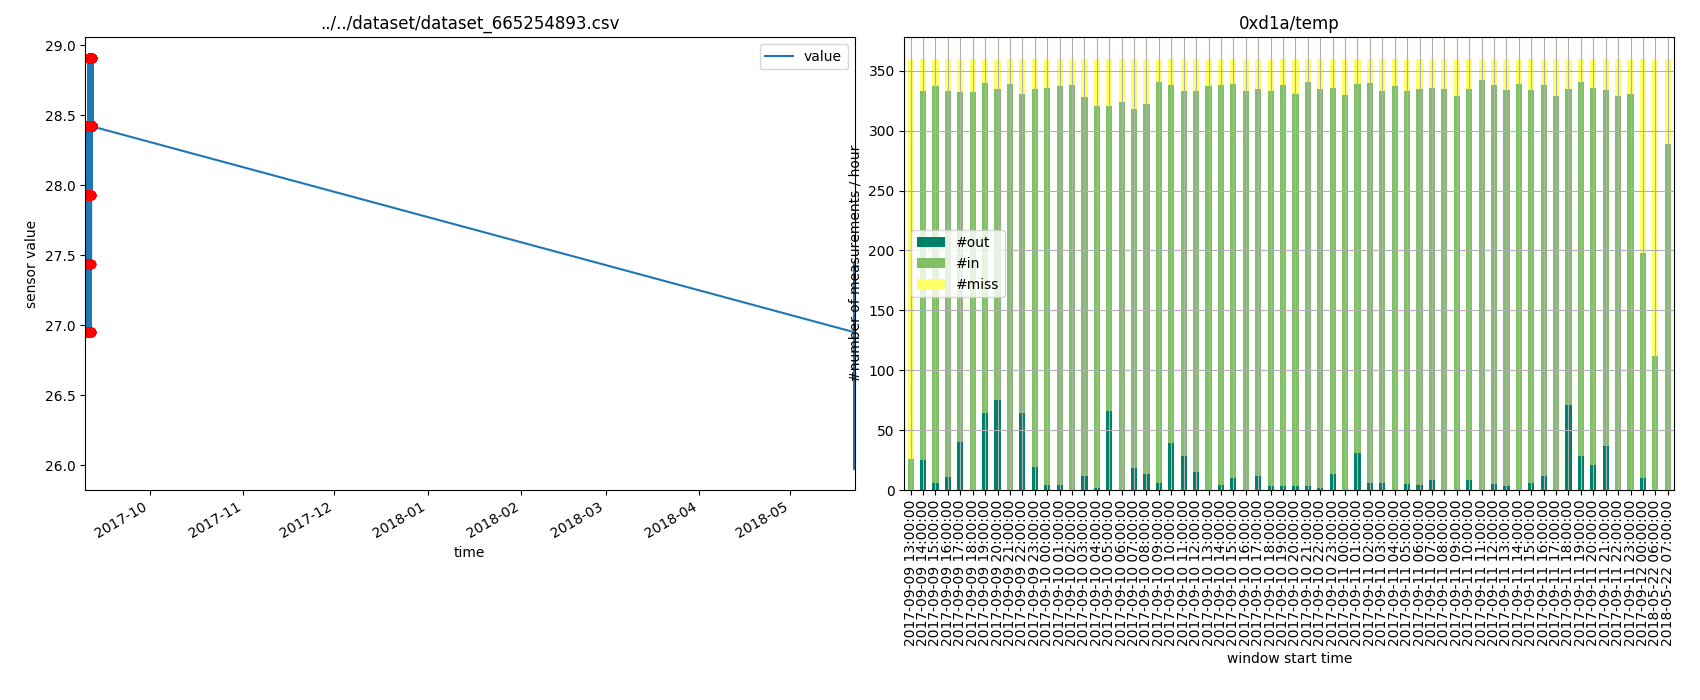

<IPython.core.display.Javascript object>


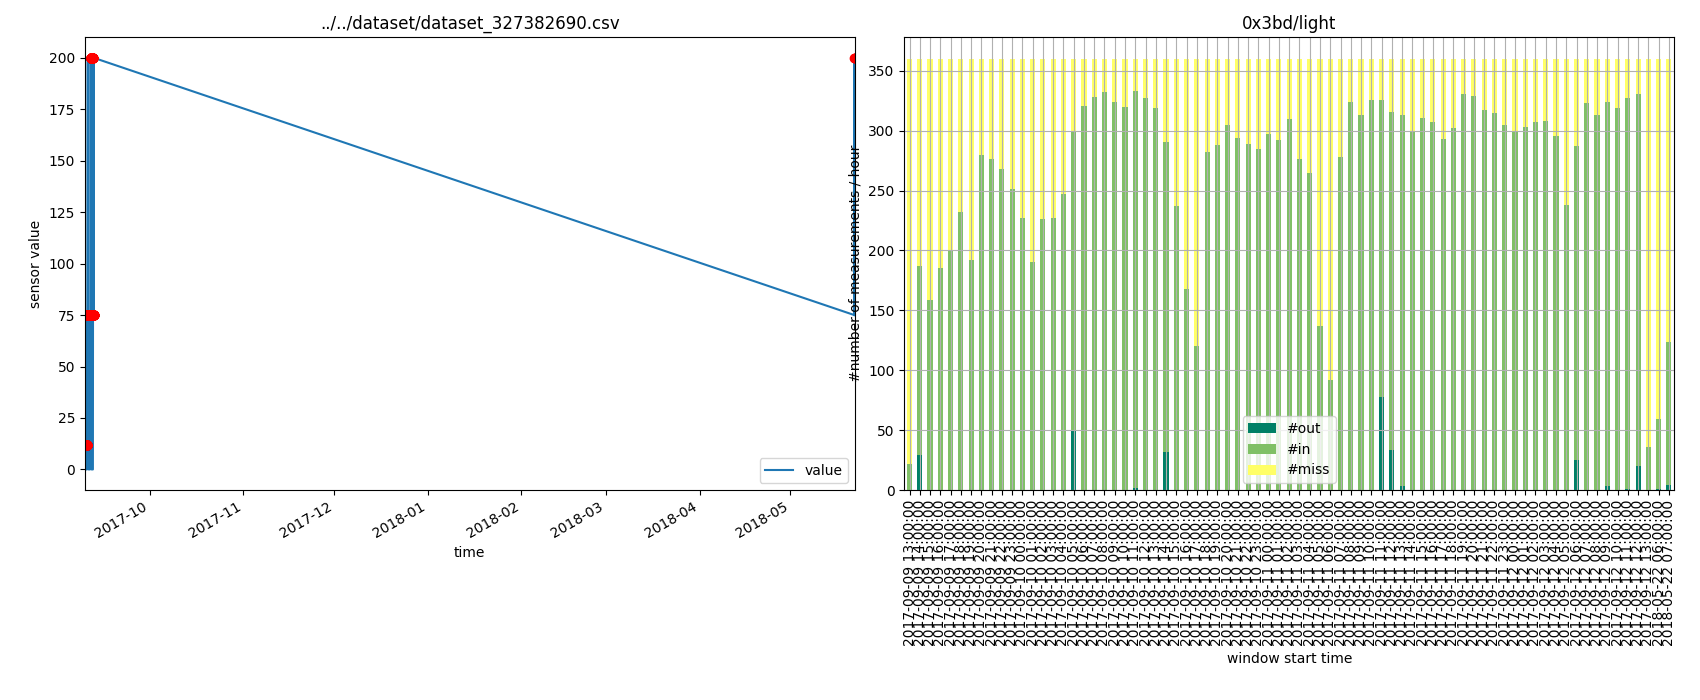

<IPython.core.display.Javascript object>


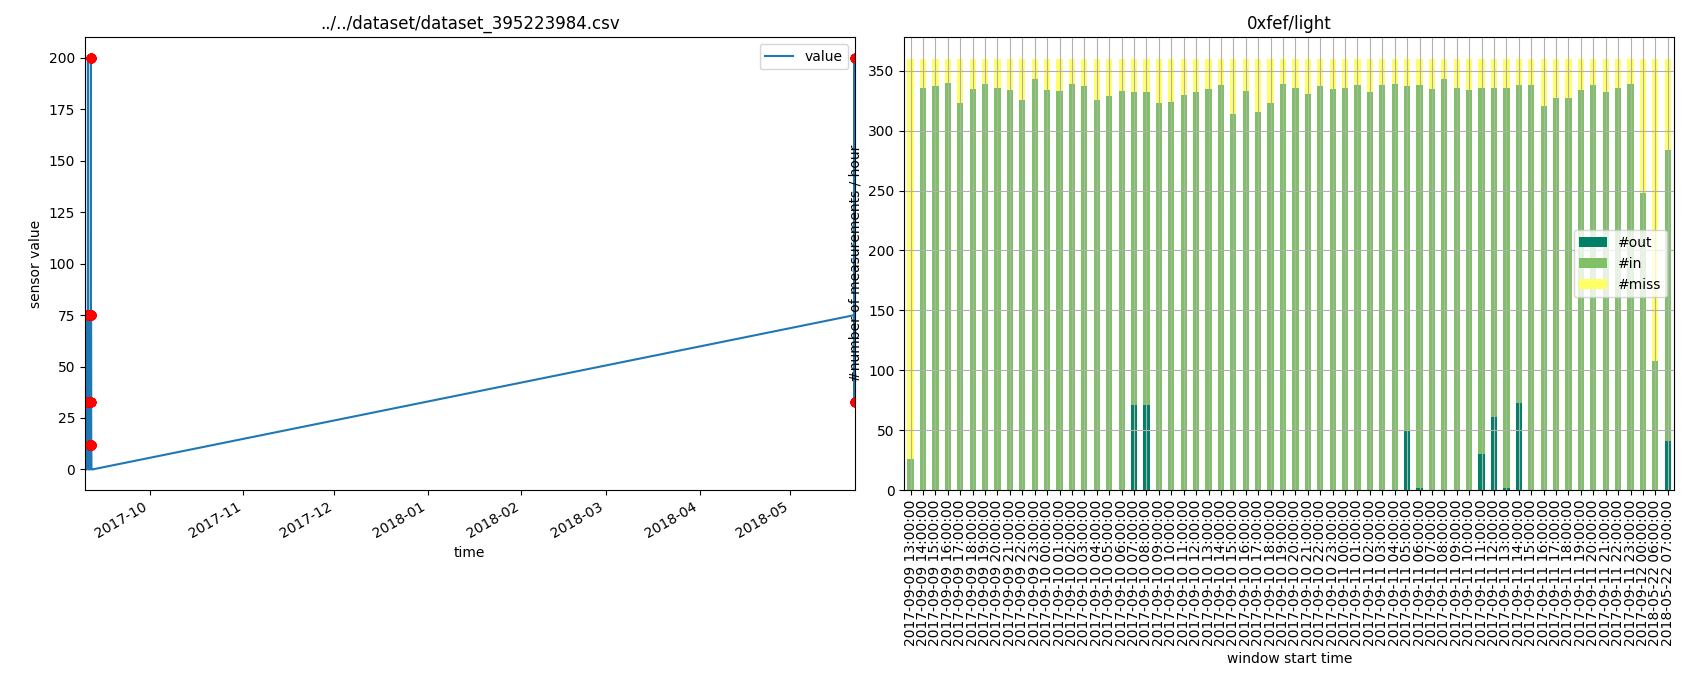

<IPython.core.display.Javascript object>


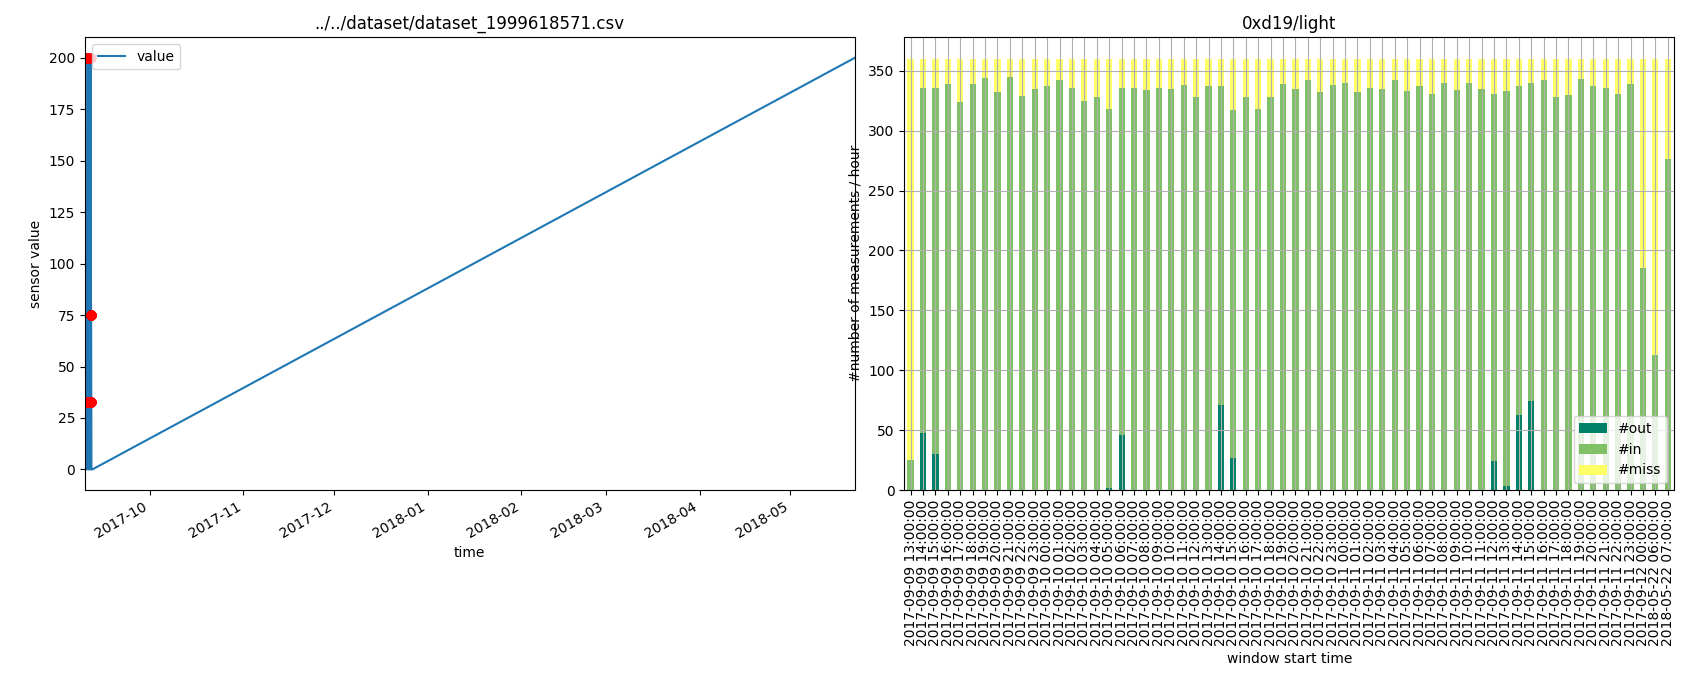

<IPython.core.display.Javascript object>


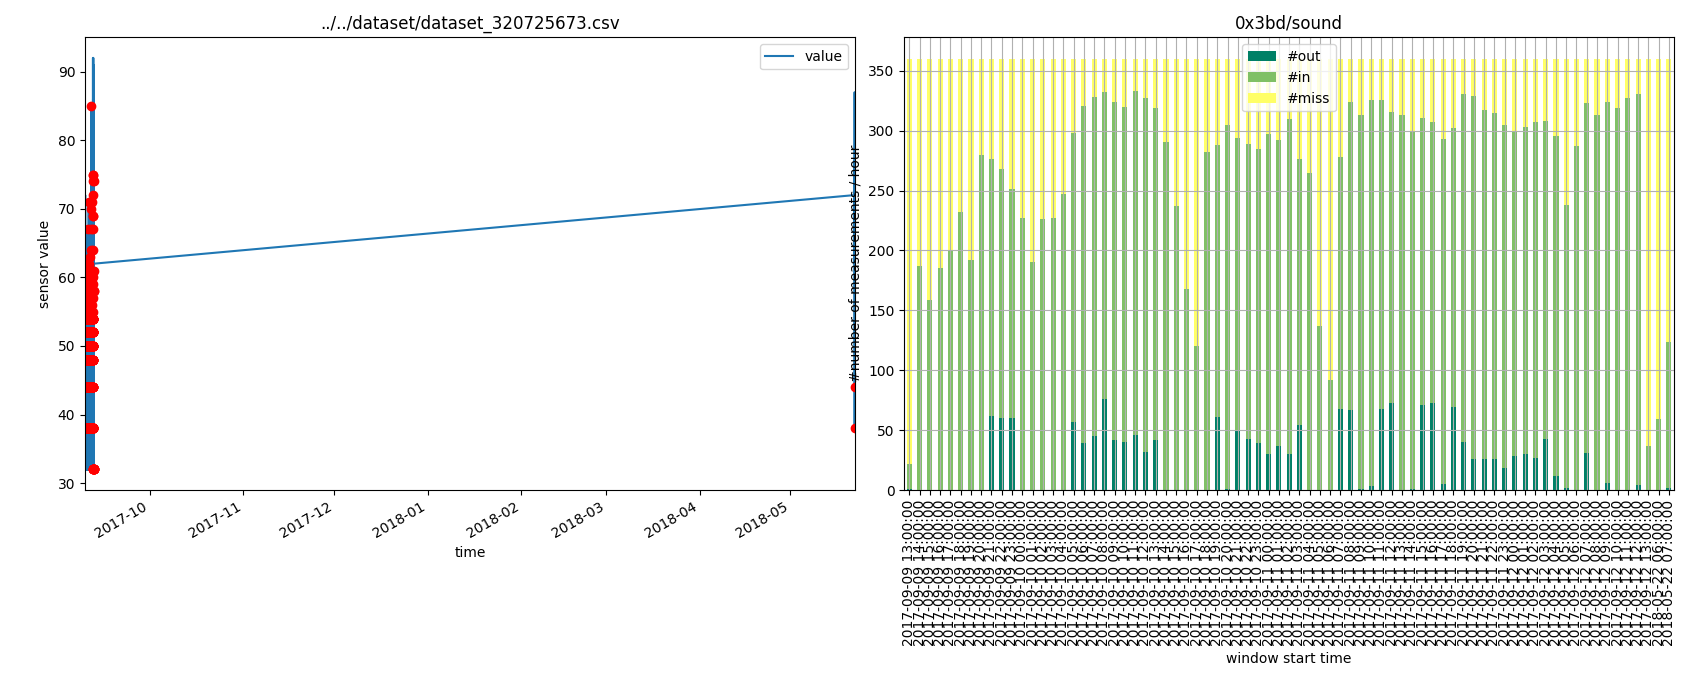

<IPython.core.display.Javascript object>


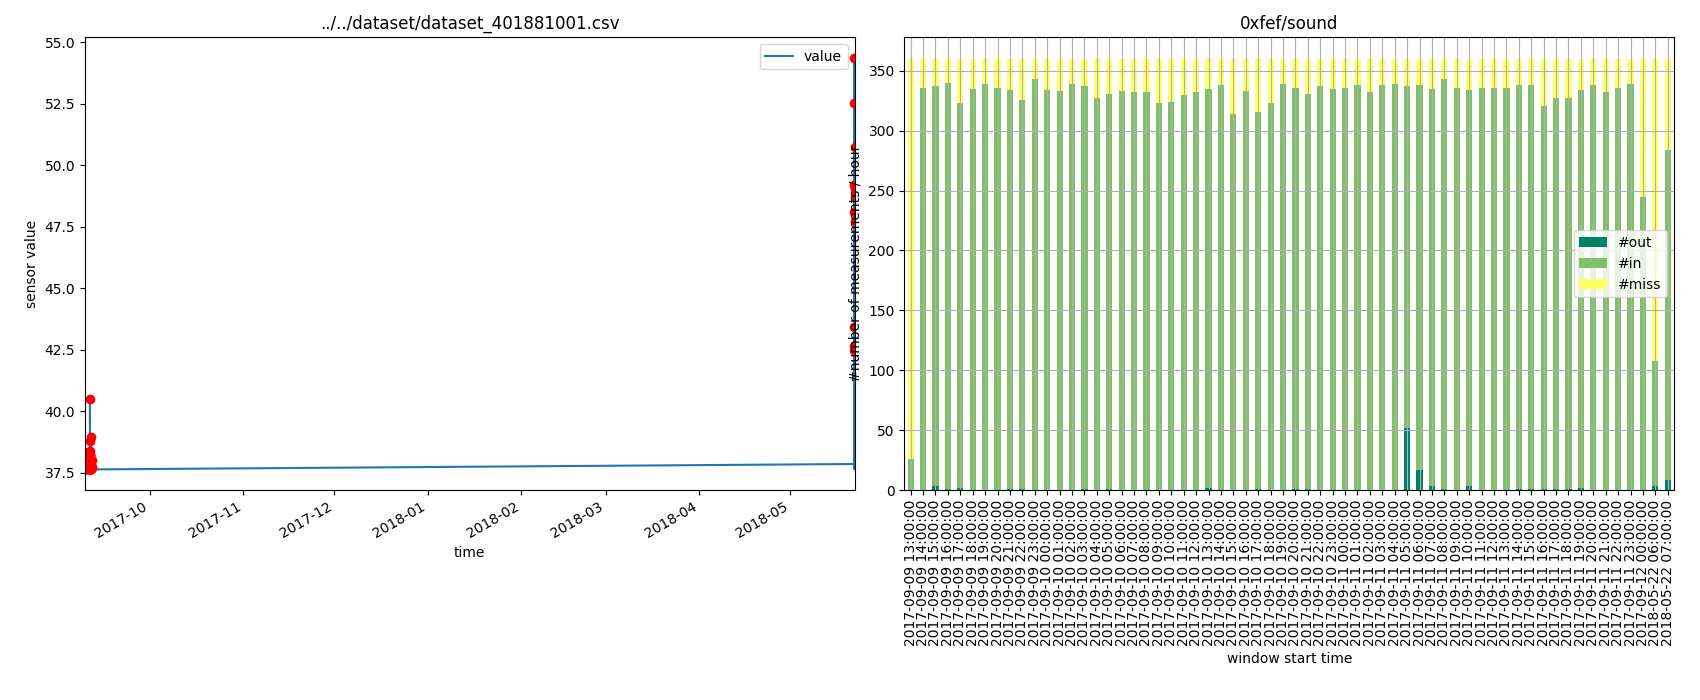

<IPython.core.display.Javascript object>


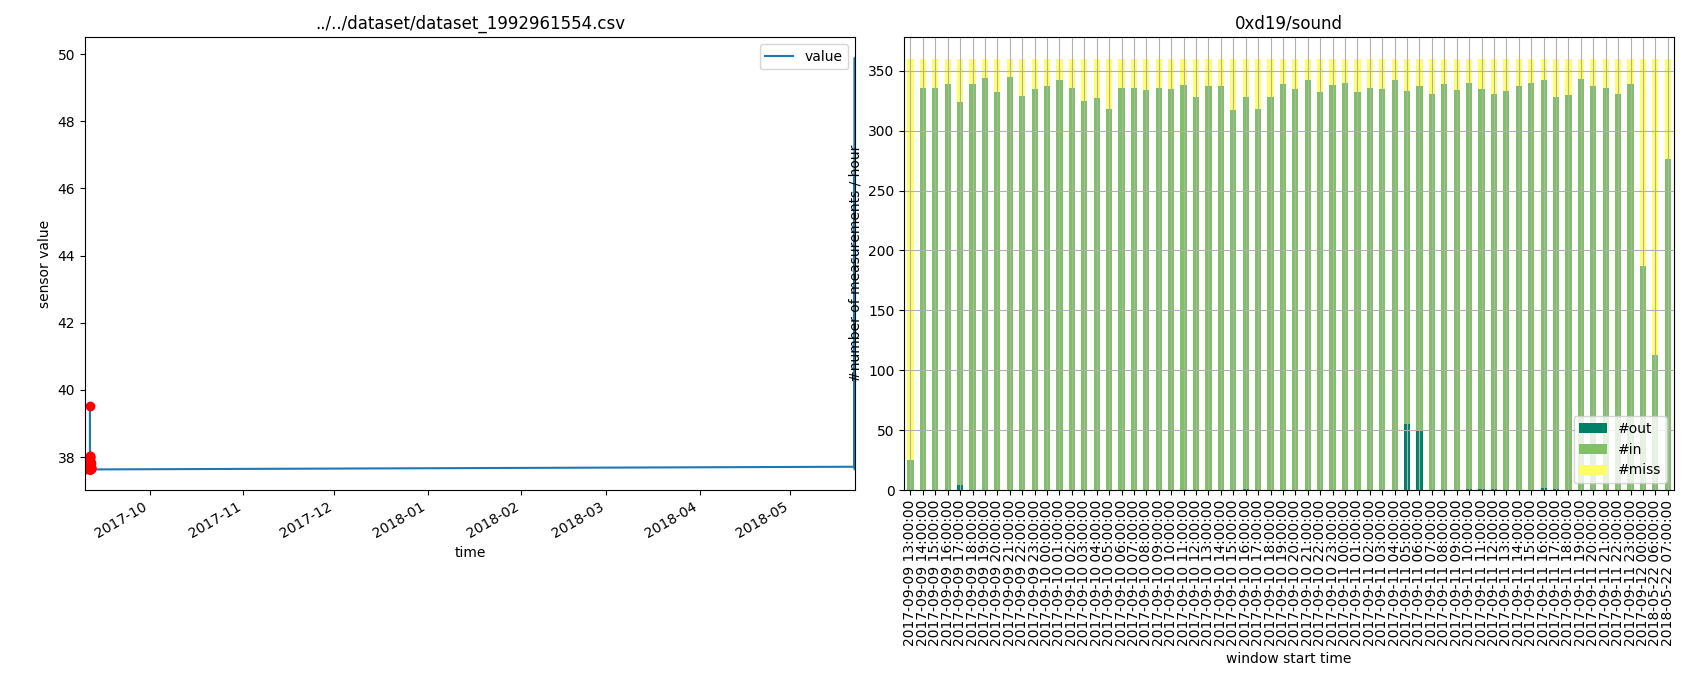

<IPython.core.display.Javascript object>


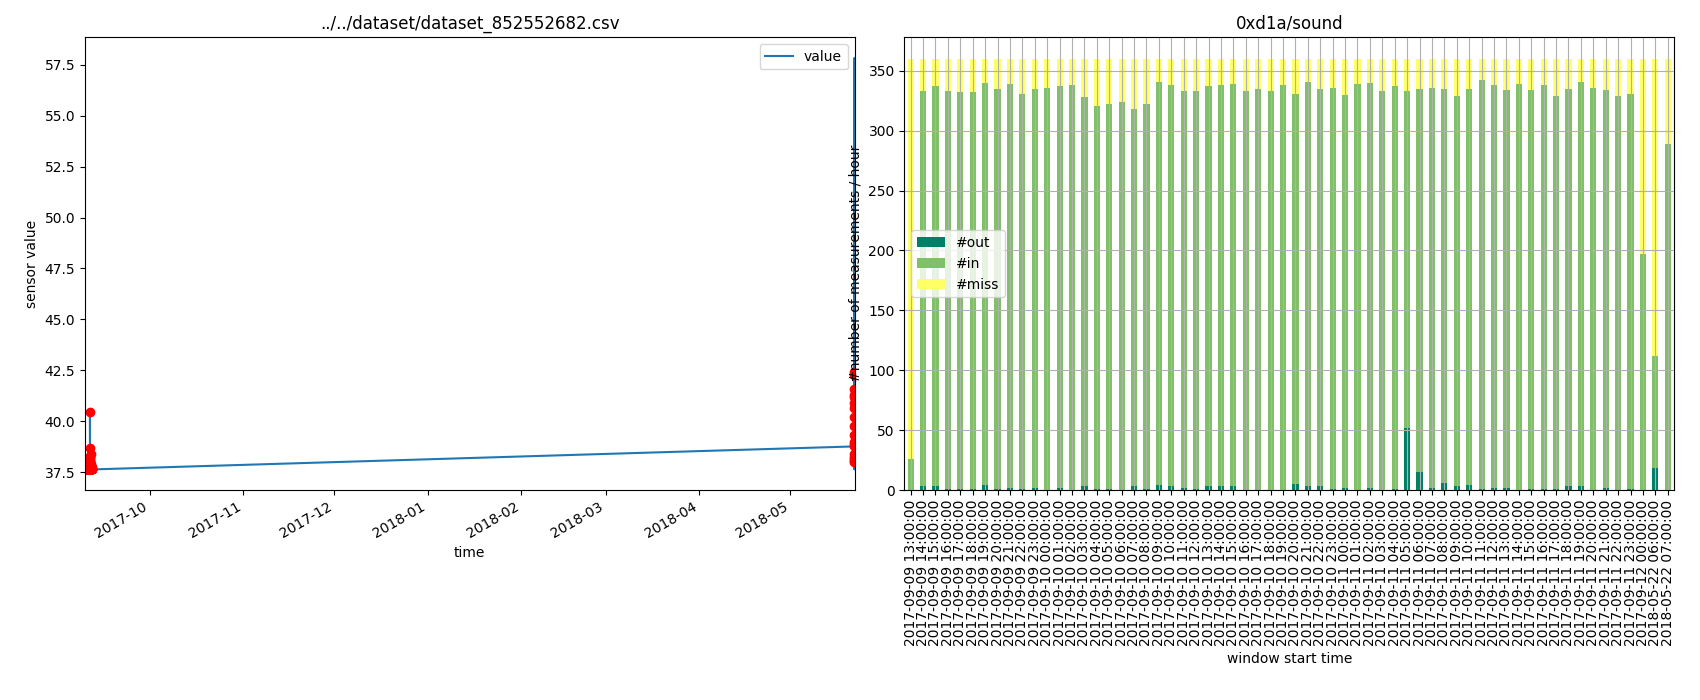

In [4]:
import utils
import math

def count_data_info_fence(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    ret = pd.DataFrame(columns = col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    
    cols = ['id', 'ts', 'val']
    
    out_ret = pd.DataFrame(columns = cols)
    in_ret = pd.DataFrame(columns = cols)
    
    for start, end, window in gen:
        if len(window) == 0:
            continue
        else:
            in_row, out_row = count_outliers(window, val_index)
            out_row.columns = cols
            out_ret = out_ret.append(out_row)
            in_row.columns = cols
            in_ret = in_ret.append(in_row)
        nout = len(out_row)
        nin = len(in_row)
        nmiss = abs(expected_num_measurements - nout - nin)
        
        tmp = pd.DataFrame([[name, start, end, nout, nin, nmiss]],columns = col)
        ret = ret.append(tmp)
        
    return in_ret, out_ret, ret

def plot_outlier_df(df, fig, ax, title = ''):
    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)
    
    df.plot(x = 1, y = [3,4,5], ax = ax, kind = 'bar', stacked = 'True', colormap = 'summer', title = title)

    ax.set_xlabel('window start time')
    ax.set_ylabel('#number of measurements / hour')
    ax.xaxis_date()
    ax.legend()
    ax.grid()

    
to_plot = t_path + l_path + s_path
res = []
for temp_path in to_plot:
    path = os.path.join(root, temp_path)
    df = pd.read_csv(path, header=None)
    inl, out, df_to_plot = count_data_info_fence(df)
    
    name = df_to_plot.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    df.columns = ['id', 'ts', 'value']
    df = df.astype({'ts':'datetime64[ms]'})
    
    fig, ax  = plt.subplots(nrows = 1, ncols = 2)
    fig.tight_layout()
    df.plot(ax = ax[0], x=1, y=[2], kind='line', title = path)
    
    x = []
    y = []
    for l in out.values:
        x.append(l[1])
        y.append(l[2])
    x = np.array(x)
    y = np.array(y)
    ax[0].plot(x.astype('datetime64[ms]'), y, 'ro')   
    
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('sensor value')
    ax[0].legend()
    ax[0].xaxis_date()
    
    plot_outlier_df(df_to_plot, fig, ax[1], name)
    
    num_missed = df_to_plot.iloc[:,5].values.sum()
    num_out = df_to_plot.iloc[:,3].values.sum()
    num_in = df_to_plot.iloc[:,4].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

# Stats over 1 hour aggregation

|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|968|19032|7000|4.84|
|0xfef/temp|976|19024|2320|4.88|
|0xd19/temp|1082|18918|2320|5.41|
|0xd1a/temp|825|19175|2320|4.125|
|0x3bd/light|339|19661|7000|1.695|
|0xfef/light|543|19457|2320|2.715|
|0xd19/light|469|19531|2320|2.345|
|0x3bd/sound|2285|17715|7000|11.425|
|0xfef/sound|125|19875|2320|0.625|
|0xd19/sound|116|19884|2320|0.58|
|0xd1a/sound|191|19809|2320|0.955|


# Stats over half hour aggregation

|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|1424|18576|6460|7.12|
|0xfef/temp|745|19255|1960|3.725|
|0xd19/temp|1081|18919|1960|5.405|
|0xd1a/temp|988|19012|1960|4.94|
|0x3bd/light|257|19743|6460|1.285|
|0xfef/light|350|19650|1960|1.75|
|0xd19/light|170|19830|1960|0.85|
|0x3bd/sound|1726|18274|6460|8.63|
|0xfef/sound|96|19904|1960|0.48|
|0xd19/sound|66|19934|1960|0.33|
|0xd1a/sound|168|19832|1960|0.84|
